
Tìm tham số tối ưu cho KNN...


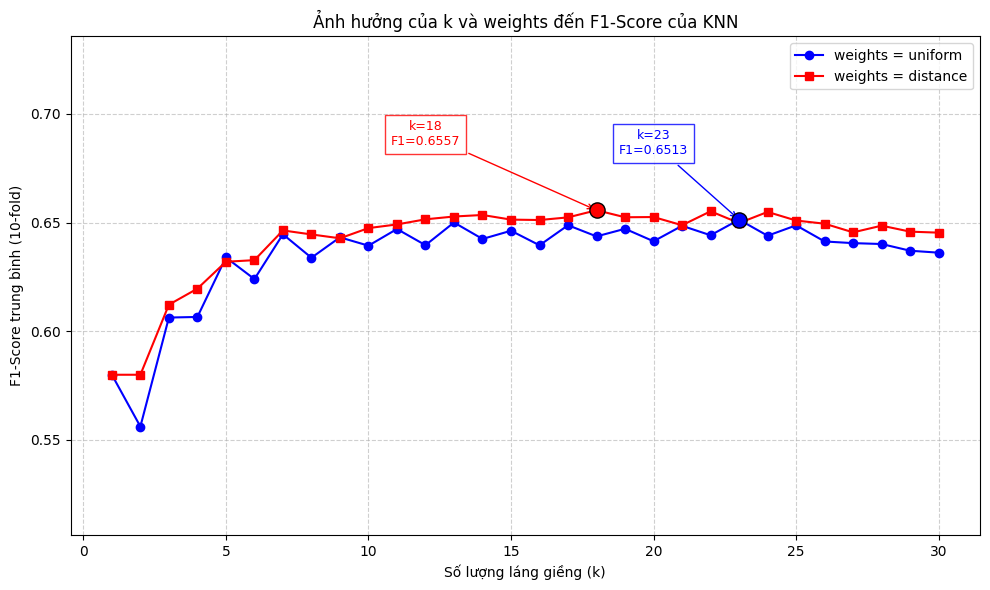

Weights = uniform =>Best k = 23, F1 = 0.6513
Weights = distance =>Best k = 18, F1 = 0.6557

Tìm tham số tối ưu cho RandomForest...


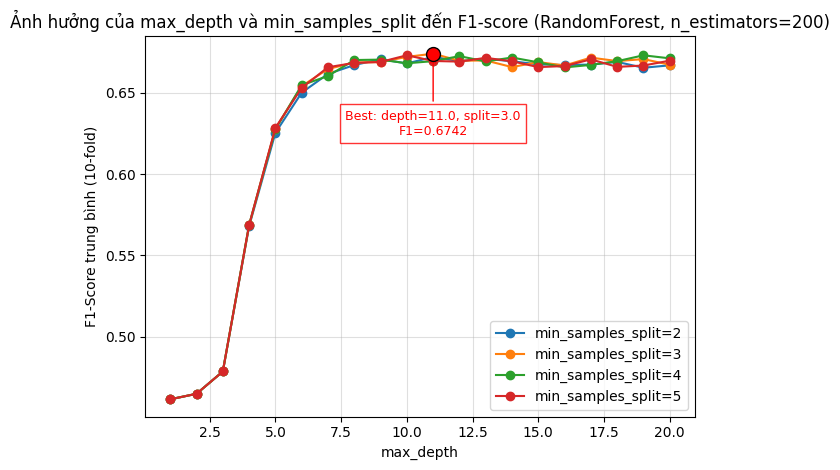


Best Parameters: max_depth=11.0, min_samples_split=3.0, F1=0.6742

Tìm tham số tối ưu cho SVM...


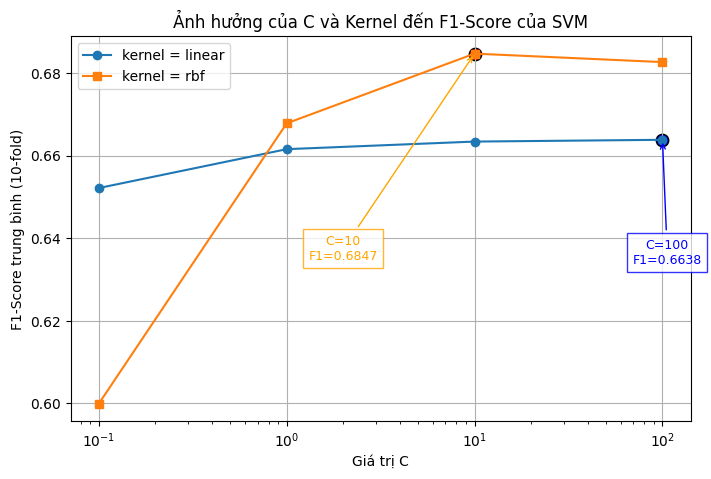

Kernel = linear → Best C = 100, F1 = 0.6638
Kernel = rbf → Best C = 10, F1 = 0.6847

Đang tinh chỉnh tham số cho mô hình KNN ...

Đang tinh chỉnh tham số cho mô hình RandomForest ...

Đang tinh chỉnh tham số cho mô hình SVM ...

Kết quả so sánh hiệu năng:
          Model                                        Best Params  F1-Score
0           SVM                       {'C': 10.0, 'kernel': 'rbf'}  0.684729
1  RandomForest  {'n_estimators': 200, 'max_depth': 11, 'min_sa...  0.674188
2           KNN         {'n_neighbors': 18, 'weights': 'distance'}  0.655659


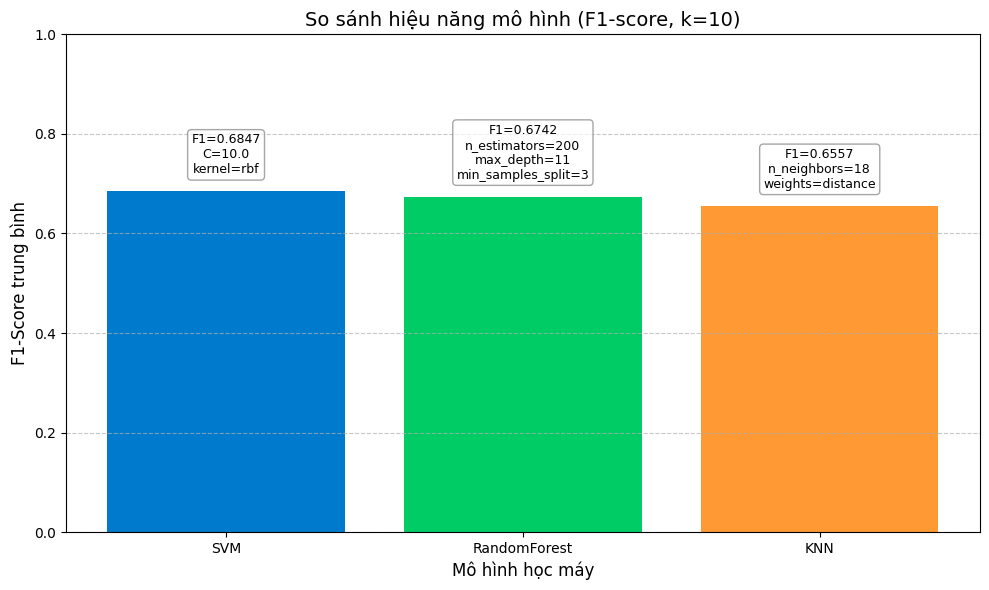

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# --- 1. Đọc dữ liệu ---
df = pd.read_csv("abalone_data.csv")

# --- 2. Mã hóa cột phân loại ---
le = LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])

# --- 3. Chia dữ liệu ---
X = df.drop('Rings', axis=1)
y = df['Rings']

# Chuyển bài toán Regression -> Classification (3 nhóm tuổi)
y = pd.cut(y, bins=[0, 8, 11, 30], labels=[0, 1, 2])
y = y.astype(int)

# --- 4. Chuẩn hóa ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 5. 10-fold Cross Validation ---
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


# =========================================================
# Vẽ biểu đồ ảnh hưởng của k đến F1-score (KNN)
# =========================================================
print("\nTìm tham số tối ưu cho KNN...")

neighbors = list(range(1, 31))
f1_uniform = []
f1_distance = []

# Tính F1-score trung bình cho mỗi k và mỗi loại weight
for k in neighbors:
    knn_u = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    knn_d = KNeighborsClassifier(n_neighbors=k, weights='distance')
    f1_u = cross_val_score(knn_u, X_scaled, y, cv=kf, scoring=make_scorer(f1_score, average='macro')).mean()
    f1_d = cross_val_score(knn_d, X_scaled, y, cv=kf, scoring=make_scorer(f1_score, average='macro')).mean()

    f1_uniform.append(f1_u)
    f1_distance.append(f1_d)

# Chuyển sang numpy array để xử lý dễ hơn
f1_uniform = np.array(f1_uniform)
f1_distance = np.array(f1_distance)

# Tìm best k và giá trị F1 tương ứng
best_idx_uniform = int(np.argmax(f1_uniform))
best_k_uniform = neighbors[best_idx_uniform]
best_f1_uniform = float(f1_uniform[best_idx_uniform])

best_idx_distance = int(np.argmax(f1_distance))
best_k_distance = neighbors[best_idx_distance]
best_f1_distance = float(f1_distance[best_idx_distance])

# --- VẼ BIỂU ĐỒ ---
plt.figure(figsize=(10,6))
plt.plot(neighbors, f1_uniform, marker='o', label='weights = uniform', color='blue')
plt.plot(neighbors, f1_distance, marker='s', label='weights = distance', color='red')

# Đánh dấu điểm tốt nhất (dùng edgecolors để tránh warning)
plt.scatter([best_k_uniform], [best_f1_uniform], color='blue', edgecolors='black', s=120, zorder=5)
plt.scatter([best_k_distance], [best_f1_distance], color='red', edgecolors='black', s=120, zorder=5)

plt.annotate(
    f"k={best_k_uniform}\nF1={best_f1_uniform:.4f}",
    xy=(best_k_uniform, best_f1_uniform),
    xytext=(best_k_uniform-3, best_f1_uniform+0.03),
    arrowprops=dict(arrowstyle="->", color='blue'),
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='blue'),
    color='blue',
    fontsize=9,
    ha='center'
)

plt.annotate(
    f"k={best_k_distance}\nF1={best_f1_distance:.4f}",
    xy=(best_k_distance, best_f1_distance),
    xytext=(best_k_distance-6, best_f1_distance+0.03),
    arrowprops=dict(arrowstyle="->", color='red'),
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='red'),
    color='red',
    fontsize=9,
    ha='center'
)

plt.xlabel('Số lượng láng giềng (k)')
plt.ylabel('F1-Score trung bình (10-fold)')
plt.title('Ảnh hưởng của k và weights đến F1-Score của KNN')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

ymin = min(f1_uniform.min(), f1_distance.min()) - 0.05
ymax = max(f1_uniform.max(), f1_distance.max()) + 0.08
plt.ylim(max(0, ymin), min(1.0, ymax))

plt.tight_layout()
plt.show()

print(f"Weights = uniform =>Best k = {best_k_uniform}, F1 = {best_f1_uniform:.4f}")
print(f"Weights = distance =>Best k = {best_k_distance}, F1 = {best_f1_distance:.4f}")


#==========================================================
#Vẽ biểu đồ tham số mô hình Random Forest
# =========================================================
print("\nTìm tham số tối ưu cho RandomForest...")

max_depths = range(1, 21)
splits = [2, 3, 4, 5]
results = []

for split in splits:
    f1_scores = []
    for depth in max_depths:
        rf = RandomForestClassifier(
            n_estimators=200,
            max_depth=depth,
            min_samples_split=split,
            random_state=42
        )
        f1 = cross_val_score(
            rf, X_scaled, y,
            cv=kf,
            scoring=make_scorer(f1_score, average='macro'),
            n_jobs=-1
        ).mean()
        f1_scores.append(f1)
        results.append({"max_depth": depth, "min_samples_split": split, "f1_score": f1})
    plt.plot(max_depths, f1_scores, marker='o', label=f"min_samples_split={split}")

# Tìm điểm tốt nhất trong toàn bộ kết quả
results_df = pd.DataFrame(results)
best_row = results_df.loc[results_df['f1_score'].idxmax()]

# Vẽ dấu chấm cho điểm tốt nhất
plt.scatter(best_row['max_depth'], best_row['f1_score'], color='red', s=100, edgecolor='black', zorder=5)
plt.annotate(
    f"Best: depth={best_row['max_depth']}, split={best_row['min_samples_split']}\nF1={best_row['f1_score']:.4f}",
    xy=(best_row['max_depth'], best_row['f1_score']),
    xytext=(best_row['max_depth'], best_row['f1_score'] - 0.05),
    arrowprops=dict(arrowstyle="->", color='red'),
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='red'),
    color='red',
    fontsize=9,
    ha='center'
)

# Cấu hình biểu đồ
plt.figure(1)
plt.title("Ảnh hưởng của max_depth và min_samples_split đến F1-score (RandomForest, n_estimators=200)")
plt.xlabel("max_depth")
plt.ylabel("F1-Score trung bình (10-fold)")
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

print(f"\nBest Parameters: max_depth={best_row['max_depth']}, min_samples_split={best_row['min_samples_split']}, F1={best_row['f1_score']:.4f}")


#==========================================================
#Vẽ biểu đồ tham số mô hình SVM
# =========================================================
print("\nTìm tham số tối ưu cho SVM...")

C_values = [0.1, 1, 10, 100]
kernels = ["linear", "rbf"]
results = {kernel: [] for kernel in kernels}

for kernel in kernels:
    for C in C_values:
        model = SVC(C=C, kernel=kernel, random_state=42)
        f1 = cross_val_score(
            model, X_scaled, y, cv=kf,
            scoring=make_scorer(f1_score, average='macro')
        ).mean()
        results[kernel].append(f1)

# Tìm best C cho từng kernel
best_C_linear = C_values[np.argmax(results['linear'])]
best_f1_linear = max(results['linear'])

best_C_rbf = C_values[np.argmax(results['rbf'])]
best_f1_rbf = max(results['rbf'])


# --- VẼ BIỂU ĐỒ ---
plt.figure(figsize=(8,5))
plt.plot(C_values, results['linear'], marker='o', label='kernel = linear')
plt.plot(C_values, results['rbf'], marker='s', label='kernel = rbf')

# Đánh dấu best point
plt.scatter(best_C_linear, best_f1_linear, color='blue', s=80, edgecolor='black')
plt.scatter(best_C_rbf, best_f1_rbf, color='red', s=80, edgecolor='black')

# Ghi chú
plt.annotate(
    f"C={best_C_linear}\nF1={best_f1_linear:.4f}",
    xy=(best_C_linear, best_f1_linear),
    xytext=(best_C_linear+6, best_f1_linear-0.03),
    arrowprops=dict(arrowstyle="->", color='blue'),
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='blue'),
    color='blue',
    fontsize=9,
    ha='center'
)


plt.annotate(
    f"C={best_C_rbf}\nF1={best_f1_rbf:.4f}",
    xy=(best_C_rbf, best_f1_rbf),
    xytext=(best_C_rbf-8, best_f1_rbf-0.05),
    arrowprops=dict(arrowstyle="->", color='orange'),
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='orange'),
    color='orange',
    fontsize=9,
    ha='center'
)

plt.xlabel("Giá trị C")
plt.ylabel("F1-Score trung bình (10-fold)")
plt.title("Ảnh hưởng của C và Kernel đến F1-Score của SVM")
plt.xscale("log")
plt.grid(True)
plt.legend()
plt.show()

print(f"Kernel = linear → Best C = {best_C_linear}, F1 = {best_f1_linear:.4f}")
print(f"Kernel = rbf → Best C = {best_C_rbf}, F1 = {best_f1_rbf:.4f}")


# =========================================================
# Huấn luyện + tinh chỉnh các mô hình
# =========================================================
best_knn_weights = "distance" if best_f1_distance > best_f1_uniform else "uniform"
best_knn_k = best_k_distance if best_knn_weights == "distance" else best_k_uniform

# Chọn SVM kernel tốt nhất
if best_f1_linear > best_f1_rbf:
    best_svm_kernel = "linear"
    best_svm_c = best_C_linear
    best_svm_f1 = best_f1_linear
else:
    best_svm_kernel = "rbf"
    best_svm_c = best_C_rbf
    best_svm_f1 = best_f1_rbf

# Tạo dict lưu tham số tối ưu
best_params = {
    "KNN": {
        "n_neighbors": best_knn_k,
        "weights": best_knn_weights
    },
    "RandomForest": {
        "n_estimators": 200,
        "max_depth": int(best_row["max_depth"]),
        "min_samples_split": int(best_row["min_samples_split"])
    },
    "SVM": {
        "C": float(best_svm_c),
        "kernel": best_svm_kernel
    }
}

# Danh sách mô hình
models = {
    "KNN": KNeighborsClassifier(**best_params["KNN"]),
    "RandomForest": RandomForestClassifier(random_state=42, **best_params["RandomForest"]),
    "SVM": SVC(random_state=42, **best_params["SVM"])
}

# --- Đánh giá hiệu năng bằng cross-validation ---
results = []
for name, model in models.items():
    print(f"\nĐang tinh chỉnh tham số cho mô hình {name} ...")
    f1 = cross_val_score(model, X_scaled, y, cv=kf, scoring=make_scorer(f1_score, average="macro")).mean()
    results.append({
        "Model": name,
        "Best Params": best_params[name],
        "F1-Score": f1
    })


# =========================================================
# Hiển thị bảng kết quả
# =========================================================
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="F1-Score", ascending=False).reset_index(drop=True)
print("\nKết quả so sánh hiệu năng:")
print(results_df)

# =========================================================
# Vẽ biểu đồ so sánh hiệu năng các mô hình
# =========================================================
plt.figure(figsize=(10,6))
bars = plt.bar(results_df["Model"], results_df["F1-Score"], color=['#007acc','#00cc66','#ff9933'])
plt.title("So sánh hiệu năng mô hình (F1-score, k=10)", fontsize=14)
plt.xlabel("Mô hình học máy", fontsize=12)
plt.ylabel("F1-Score trung bình", fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Hiển thị F1-score và tham số trên từng cột
for bar, (_, row) in zip(bars, results_df.iterrows()):
    yval = bar.get_height()
    params_text = "\n".join([f"{k}={v}" for k, v in row["Best Params"].items()])
    plt.text(
        bar.get_x() + bar.get_width()/2,
        yval + 0.03,
        f"F1={yval:.4f}\n{params_text}",
        ha='center', va='bottom', fontsize=9,
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray', boxstyle='round,pad=0.3')
    )

plt.tight_layout()
plt.show()
